## Intro

This notebook runs bagged sklearn trees on the multi class AG_news dataset

In [1]:
# # # local
project_directory = "../"


# # # # colab
# from google.colab import drive
# drive.mount('/content/drive')
# project_directory = "/content/drive/MyDrive/colab_working_directory/diversity-enforced-ensembles/"
# !pip install cached-property

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

# allow import of decompose locally
import sys
sys.path.append(project_directory + 'src/')

from decompose import CrossEntropy
import bvdlib
from sklearn.metrics import log_loss

from gensim.models import FastText
from gensim.utils import tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F

from ml_utils.torch_data_utils import minimal_implementation_dataset_classification
from ml_utils.ensemble_utils import SimpleMLP
from ml_utils.MCCE_ensemble_utils import Ensemble_Runner
from ml_utils.MCCE_ensemble_utils import torch_MCCE_logit_combiner
from ml_utils.MCCE_ensemble_utils import norm_geo_mean

import os

In [3]:
save_path_without_extension = project_directory + "experiments/results/ag_news_NCL"

## Pre-Process Data

In [4]:
# get data
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
train_df = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["test"])

train_labels  = train_df['label'].to_numpy()
test_labels = test_df['label'].to_numpy()

train_df = train_df['text'].to_numpy()
test_df = test_df['text'].to_numpy()

In [5]:
def tokenizedoc(data):
    tokenized_data = []
    for sent in data:
        tokenized_data.append(list(tokenize(sent)))
    return tokenized_data

tokenized_training = tokenizedoc(train_df)
tokenized_testing = tokenizedoc(test_df)

In [6]:
model = FastText(vector_size=16, window=3, min_count=1, sentences=tokenized_training, epochs=10, seed=0)

In [7]:
def gen_sent_vecs(model, token_list):
    sent_vecs = []
    for sent in token_list:
        sent_vecs.append(model.wv.get_sentence_vector(sent))
    return sent_vecs
train_data = np.array(gen_sent_vecs(model, tokenized_training))
test_data = np.array(gen_sent_vecs(model, tokenized_testing))

print("Train data shape", train_data.shape)
print("Test data shape", test_data.shape)

Train data shape (120000, 16)
Test data shape (7600, 16)


In [8]:
# reduce samples, classes remain roughly balanced
reduced_len_test = 500
reduced_len_train = 4500

test_data = test_data[:reduced_len_test]
test_labels = test_labels[:reduced_len_test]

train_labels = train_labels[:reduced_len_train]
train_data = train_data[:reduced_len_train]

In [9]:
#define settings

n_trials = 75
trial_space = np.array([0, 0.05, 0.1, 0.7, 0.9, 1.5, 2, 5]) # Test estimators from 1 to 20
num_training = int(0.8 * len(train_data))

In [10]:
# seed experiment
experiment_seed = 0
np.random.seed(experiment_seed)
torch_generator = torch.manual_seed(experiment_seed)

In [11]:
decomp_fn = CrossEntropy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype=torch.float32

criterion = torch.nn.CrossEntropyLoss()
test_dset = minimal_implementation_dataset_classification(test_data, test_labels, device, dtype)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size = len(test_dset), shuffle=False)
chosen_model = SimpleMLP
combiner_rule = torch_MCCE_logit_combiner

parameter_dictionary = {
    "epoch_n": 10,
    "estimator_n": 5,
    "batch_size" : 25,
    "hidden_size" : 8,
    "hidden_layer_num" : 2,
    "device" : device,
    "combiner_rule" : combiner_rule,
    "criterion" : criterion,
}


smoothing_factor = 1e-6
class_num = len(np.unique(train_labels))

consider_epoch_every_x_steps = 10

## Run Experiments

In [13]:
# define a trial
def trial_run(trial):
  

  #setup trial
  params = trial.get_params
  trial_estimators = params['estimator_n']
  epoch_results = []
  epoch_ens_train_losses = []
  epoch_ens_test_losses = []
  epoch_member_train_losses = []
  epoch_member_test_losses = []

  trial_x, trial_y = trial.get_data
  trial_dset = minimal_implementation_dataset_classification(trial_x, trial_y, params['device'], dtype)
  trial_dloader = torch.utils.data.DataLoader(trial_dset, batch_size = params['batch_size'], shuffle=True, generator=torch_generator)
  # trial_unshuffled_dloader = torch.utils.data.DataLoader(trial_dset, batch_size = len(trial_dset), shuffle=False)

  trial_criterion = params['criterion']
  # init model
  ensemble = []
  optims = []
  losses = []

  
  for member_n in range(trial_estimators):
      ensemble.append(SimpleMLP(len(trial_x[0]), class_num, params['hidden_size'], params['hidden_layer_num'], torch_generator).to(params['device']))
      optims.append(torch.optim.Adam(ensemble[member_n].parameters()))
      losses.append(None)
      
  ens_runner = Ensemble_Runner(ensemble[0], params['combiner_rule'])
  lambda_ = params['lambda']

  overall_trial_stepcount = 0


  #run training
  for epoch in range(params['epoch_n']):
     
    trial_results_array = np.zeros((trial_estimators, len(test_data), class_num))

    for batch_idx, (batch_x, batch_y) in enumerate(trial_dloader):
      # get detached ensemble output

      if overall_trial_stepcount % consider_epoch_every_x_steps == 0:
        
        # print(overall_trial_stepcount, batch_idx)
        member_test_losses = np.zeros((trial_estimators))
        member_train_losses = np.zeros((trial_estimators))
        with torch.no_grad():
            trial_x_to_runnable = torch.tensor(trial_x).type(torch.float32).to(params['device'])
            trial_y_to_runnable = torch.tensor(trial_y).type(torch.long).to(params['device'])
            test_x_to_runnable = torch.tensor(test_data).type(torch.float32).to(params['device'])
            test_y_to_ens_runnable = torch.tensor(test_labels).type(torch.long).to(params['device'])
            trial_ensemble_output, trial_member_output = ens_runner.forward(trial_x_to_runnable, ensemble)
            test_ensemble_output, test_member_output = ens_runner.forward(test_x_to_runnable, ensemble)
            epoch_ens_train_losses.append(trial_criterion(trial_ensemble_output, trial_y_to_runnable).cpu())
            epoch_ens_test_losses.append(trial_criterion(test_ensemble_output, test_y_to_ens_runnable).cpu())
            # print(test_ensemble_output.size(), test_y_to_ens_runnable.size())
            # print(trial_criterion(test_ensemble_output, test_y_to_ens_runnable).cpu())
            # print(test_member_output.size())
            test_member_probabilities = F.softmax(test_member_output, dim=-1)
            trial_results_array = np.array(test_member_probabilities.cpu())
            for i in range(trial_estimators):
              # print(test_y_to_ens_runnable.size())
              member_test_losses[i] = trial_criterion(test_member_output[i], test_y_to_ens_runnable).cpu()
              member_train_losses[i] = trial_criterion(trial_member_output[i], trial_y_to_runnable).cpu()
        smoothed_results = trial_results_array = (1 - smoothing_factor) * trial_results_array + smoothing_factor * (np.ones_like(trial_results_array)) * (1. / trial_results_array.shape[-1])
        epoch_results.append(np.array(smoothed_results))
        epoch_member_train_losses.append(np.sort(member_train_losses))
        epoch_member_test_losses.append(np.sort(member_test_losses))
      overall_trial_stepcount += 1
        
        

      with torch.no_grad():
        _, member_output = ens_runner.forward(batch_x, ensemble)
        
      # update each member
      for i, member in enumerate(ensemble):
        optims[i].zero_grad()
        member_pred = member(batch_x)
        member_grad_output = torch.cat((member_output[:i], member_pred.unsqueeze(dim=0), member_output[i+1:]))
        ens_grad_output = params['combiner_rule'](member_grad_output)
        # print(member_pred.dtype, batch_y.dtype, ens_grad_output.dtype)
        # print(member_pred.size(), batch_y.size(), ens_grad_output.size())
        losses[i] = ((trial_criterion(member_pred, batch_y)) - ((lambda_) * trial_criterion(member_pred, ens_grad_output)))
        losses[i].backward()
        optims[i].step()
      # print(member_loss)
  # print(epoch_results)
  # print(len(epoch_results), len(epoch_ens_train_losses), len(epoch_member_train_losses), len(epoch_member_test_losses), len(epoch_ens_test_losses))
  return epoch_results, epoch_ens_train_losses, epoch_member_train_losses, epoch_member_test_losses, epoch_ens_test_losses

# save results
  
total_step_count_estimate = (parameter_dictionary['epoch_n'] * (num_training // parameter_dictionary['batch_size']))
results_objs = -(total_step_count_estimate // -consider_epoch_every_x_steps) # ceiling divison plus 0 step result object
study = bvdlib.NCL_Study(trial_space, parameter_dictionary, train_data, train_labels, test_data, test_labels, 
                    num_training, n_trials, decomp_fn, num_results_objects=results_objs, estimator_n=parameter_dictionary['estimator_n'])

results = study.run_trials(trial_run)

if not os.path.exists(save_path_without_extension):
    os.makedirs(save_path_without_extension)

for epoch, result in enumerate(results):
  this_save_path = save_path_without_extension + "/stepmeasure_" + str(epoch) + ".pkl"
  result.save_results(this_save_path)

  0%|          | 0/7 [08:33<?, ?it/s]


KeyboardInterrupt: 

96


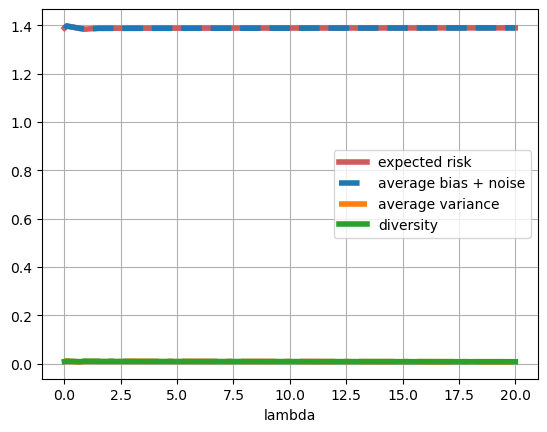

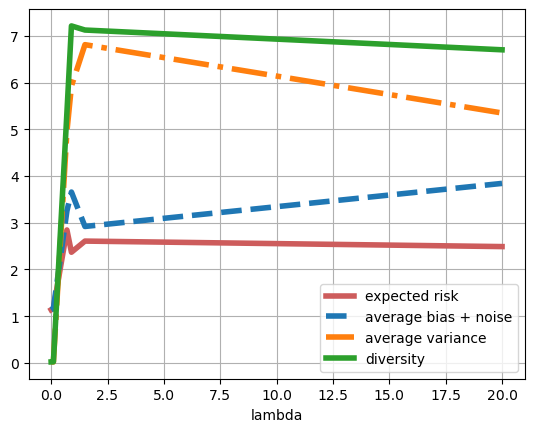

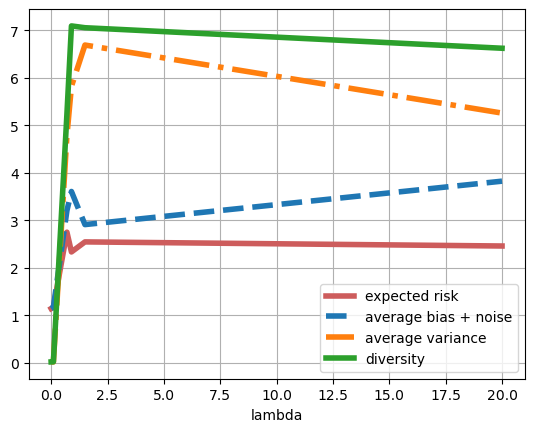

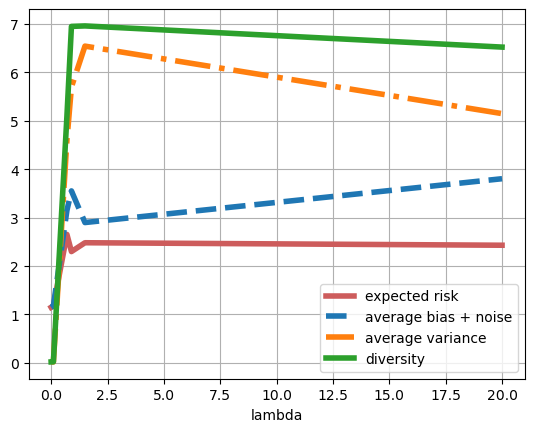

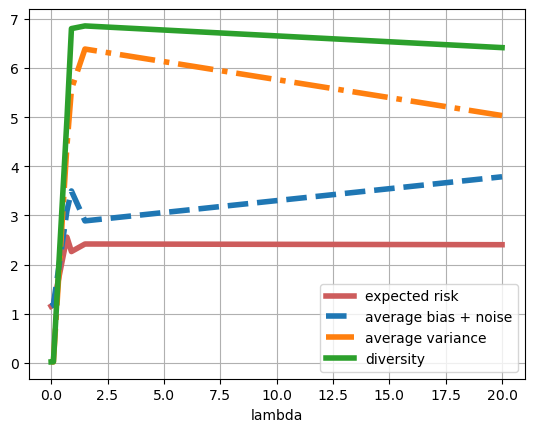

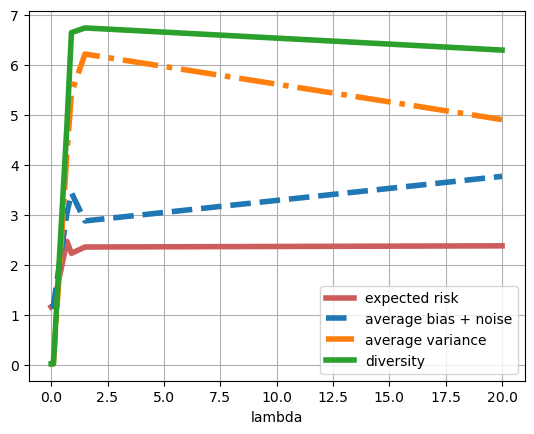

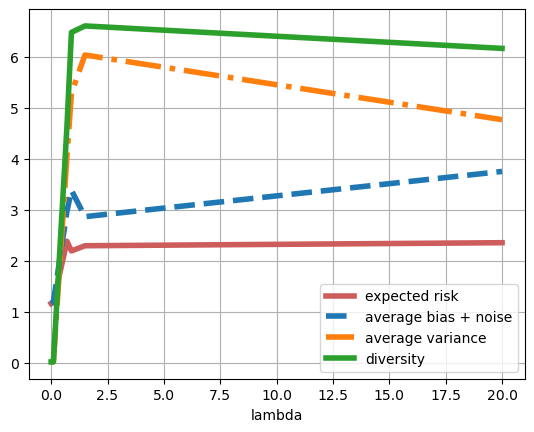

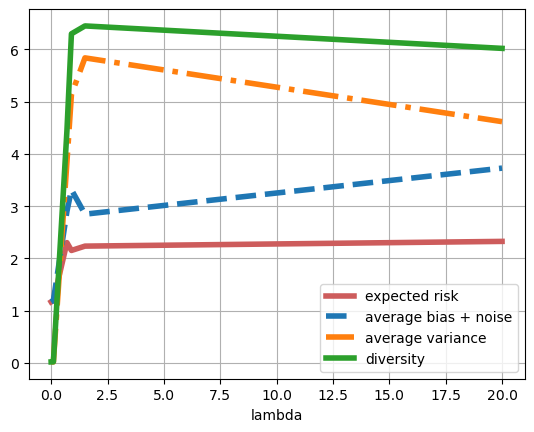

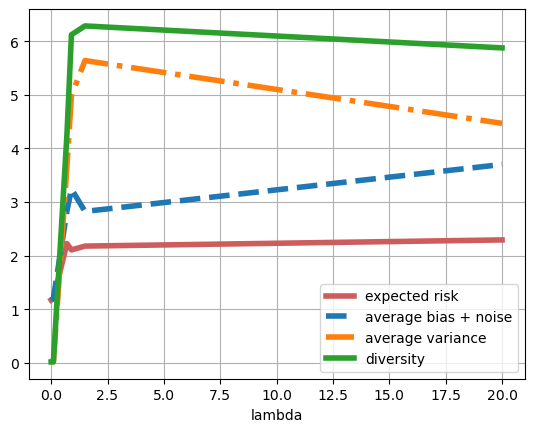

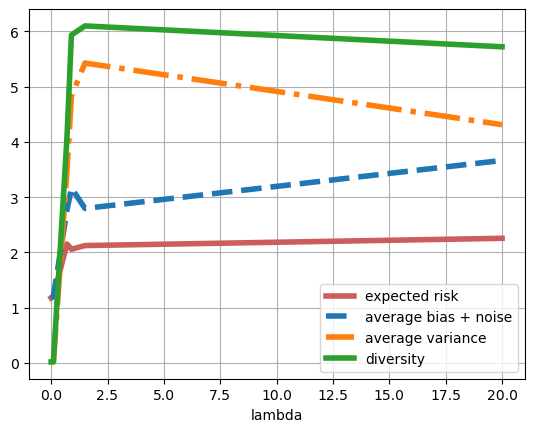

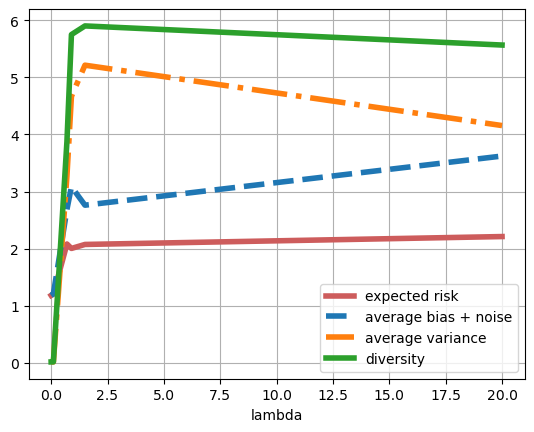

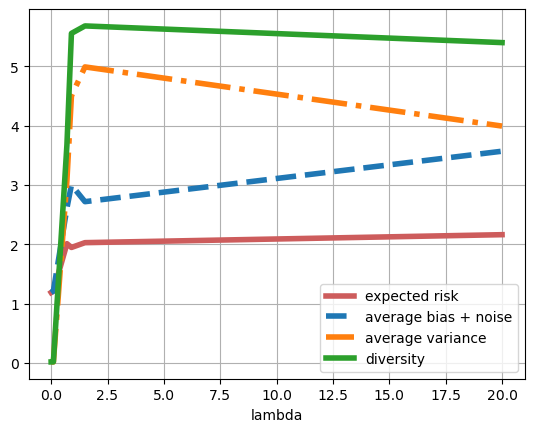

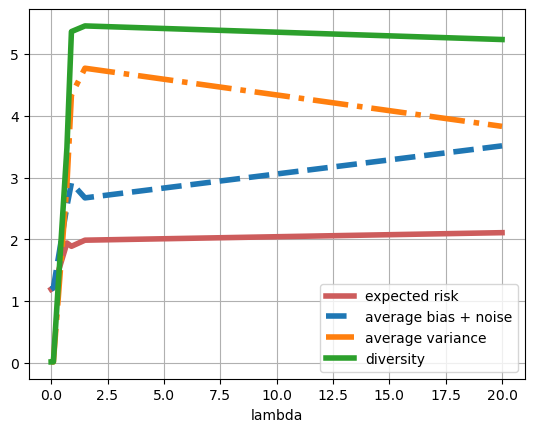

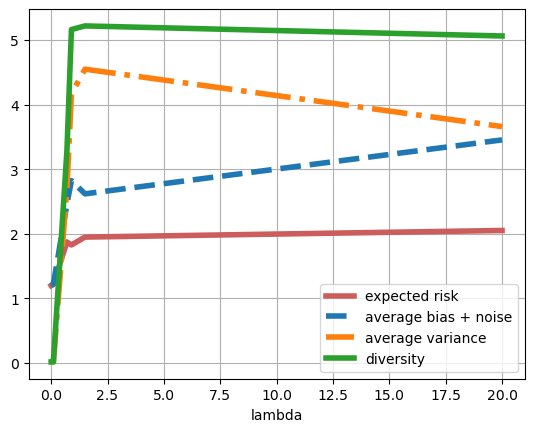

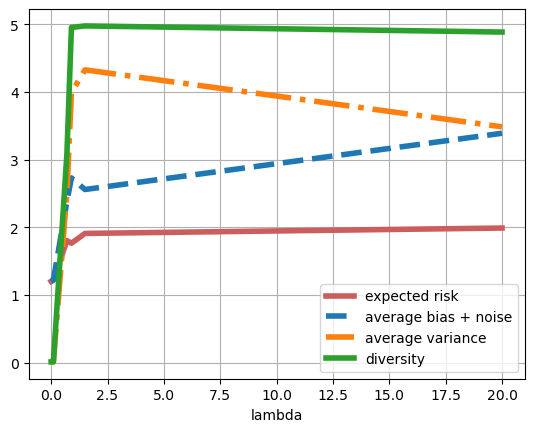

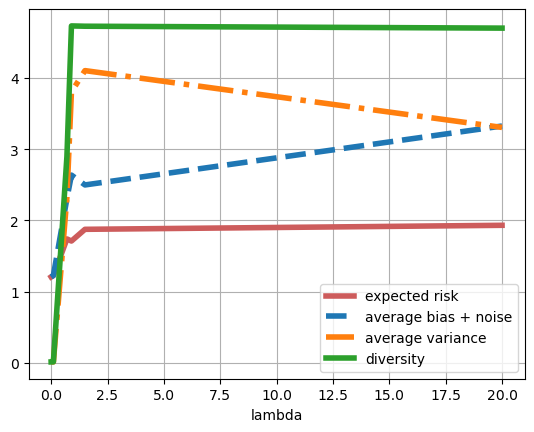

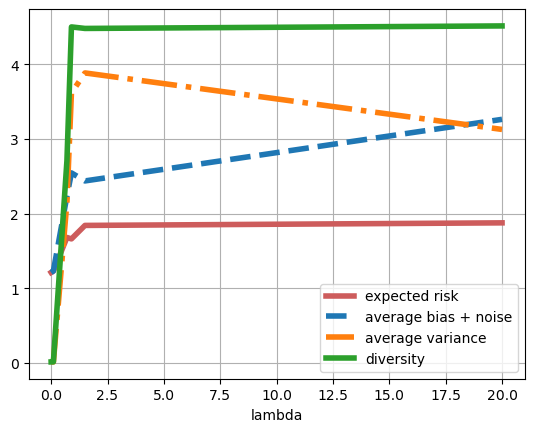

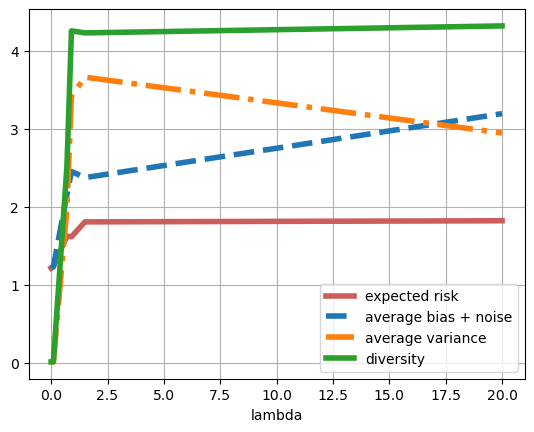

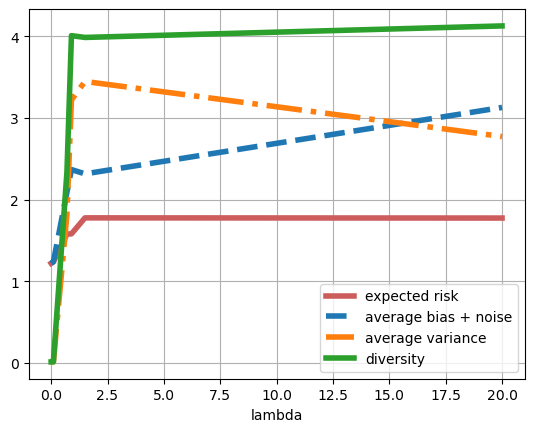

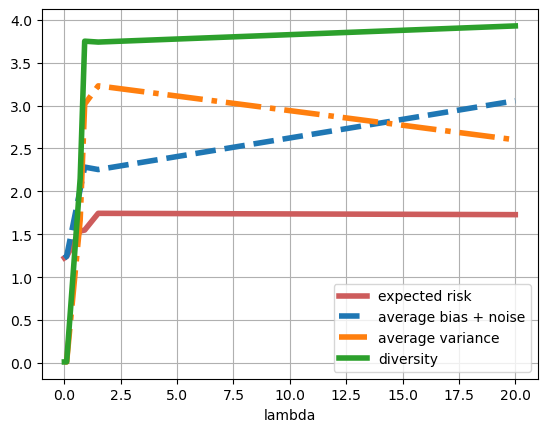

In [ ]:
from decompose.plotting_utils import plot_bvd
print(len(results))
results_idx = 25

for i in range(20):
    ax = plot_bvd(results[-i+1])